In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [48]:
 import glob
import math
import torch
import ants

import numpy as np
import seaborn as sns
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
import datasets
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from functools import partial
from einops import rearrange
from models.flows import ScoreAttentionBlock, PatchFlow, gaussian_logprob

2023-08-07 15:18:06.373563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import sde_lib
from models import ncsnpp3d
from models import utils as mutils
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint, restore_pretrained_weights, save_checkpoint
from configs.flows import biggan_default as configs
config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

### Load the data

In [8]:
config.data.ood_ds = "lesion_load_20"
config.data.cache_rate = 0.0
config.eval.batch_size = 16
config.data

as_tfds: false
cache_rate: 0.0
centered: false
colab_path: /content/drive/MyDrive/ML_Datasets/ABCD/processed/
colab_splits_path: /content/drive/MyDrive/Developer/braintypicality/dataset/
colab_tumor_path: /content/drive/MyDrive/ML_Datasets/ABCD/tumor/
dataset: BRAIN
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
gen_ood: false
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
ood_ds: lesion_load_20
select_channel: -1
spacing_pix_dim: 2.0
splits_path: /home/braintypicality/dataset/
tumor_dir_path: /DATA/Users/amahmood/tumor/
uniform_dequantization: false

In [10]:
%%time
inlier_ds, ood_ds, _ = datasets.get_dataset(
    config, evaluation=True, ood_eval=True,
)
x_inlier = torch.cat([x["image"] for x in inlier_ds])

In [13]:
%%time
x_ood = []
x_ood_labels = []
for x in ood_ds:
    x_ood.append(x["image"])
    x_ood_labels.append(x["label"])

x_ood = torch.cat(x_ood)
x_ood_labels = torch.cat(x_ood_labels)

CPU times: user 3.4 s, sys: 648 ms, total: 4.05 s
Wall time: 11.2 s


In [21]:
x_inlier.shape, x_ood.shape

(torch.Size([86, 2, 96, 112, 80]), torch.Size([86, 2, 96, 112, 80]))

In [14]:
config.flow

context_embedding_size: 128
ema_halflife_kimg: 50
ema_rampup_ratio: 0.05
ema_rate: 0.9999
global_embedding_dim: 512
global_flow: true
gmm_components: -1
log_interval: 10
log_tensorboard: true
log_wandb: true
lr: 0.0003
ndims: 128
num_blocks: 4
patch_batch_size: 128
patch_size: 17
training_kimg: 50

In [15]:
# Initialize score model
score_model = mutils.create_model(config, log_grads=False)
ema = ExponentialMovingAverage(
    score_model.parameters(), decay=config.model.ema_rate
)
state = dict(model=score_model, ema=ema)

# Get the latest score model checkpoint from workdir
checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_paths = glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.pth"))
latest_checkpoint_path = max(
    checkpoint_paths, key=lambda x: int(x.split("_")[-1][1])
)
state = restore_checkpoint(latest_checkpoint_path, state, config.device)
ema.store(score_model.parameters())
ema.copy_to(score_model.parameters())
score_model.eval().requires_grad_(False)

scorer = mutils.build_score_norm_fn(config, score_model, return_norm=False)

In [27]:
config.flow.patch_size = 3
config.flow.gmm_components = -1
config.flow.num_blocks = 8

# Initialize flow model
flownet = PatchFlow(
    input_size=(config.msma.n_timesteps, *config.data.image_size),
    patch_size=config.flow.patch_size,
    patch_batch_size=config.flow.patch_batch_size,
    global_flow=config.flow.global_flow,
    gmm_components=config.flow.gmm_components,
    global_embedding_dim = config.flow.global_embedding_dim
).cuda()

flow_path = f"{workdir}/flow/psz{config.flow.patch_size}-nb{config.flow.num_blocks}-gmm{config.flow.gmm_components}-lr0.0003-bs{16}-pbs{config.flow.patch_batch_size}-kimg50/"
state_dict = torch.load(f"{flow_path}/checkpoint.pth", map_location=torch.device('cpu'))
flownet.load_state_dict(state_dict["model_state_dict"], strict=False)
print("Loaded", state_dict['kimg'],state_dict['val_loss'])

Generating 3x3x3 patches from input size: (20, 96, 112, 80)
Pooled spatial resolution: (48, 56, 40)
Number of flows / patches: 107520
Global Context Shape:  (20, 15, 18)
Loaded 3125 -59.13318634033203


In [16]:
%%time
x_inlier_scores = torch.cat([scorer(x) for x in x_inlier.chunk(5)])
x_inlier_scores.shape

CPU times: user 1min 45s, sys: 3.53 s, total: 1min 49s
Wall time: 57.8 s


torch.Size([86, 20, 96, 112, 80])

In [23]:
%%time
x_ood_scores = torch.cat([scorer(x) for x in x_ood.chunk(4)])
x_ood_scores.shape

CPU times: user 1min 36s, sys: 3.53 s, total: 1min 39s
Wall time: 56.8 s


torch.Size([86, 20, 96, 112, 80])

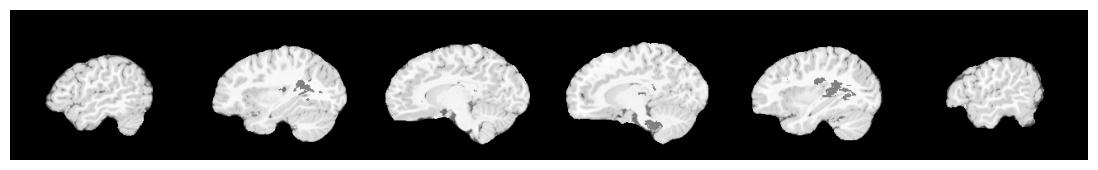

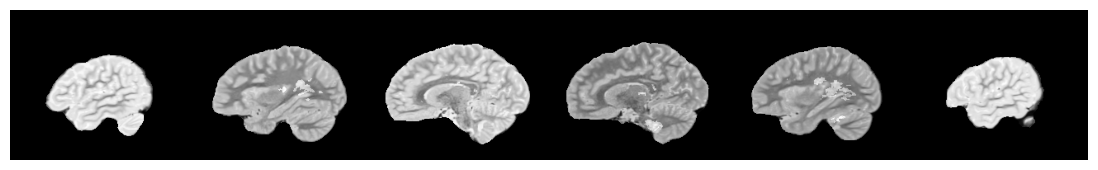

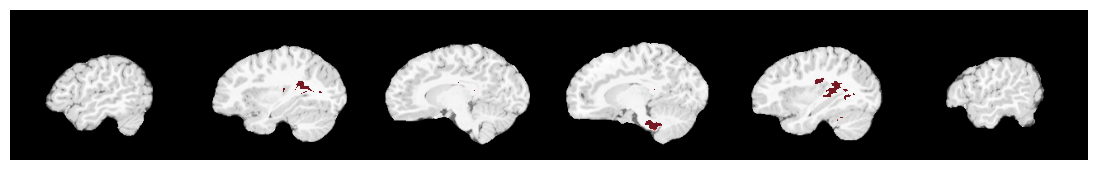

In [24]:
dirname = "/ASD/ahsan_projects/lesion_samples/processed/"
t1, t2, labels = ants.image_read(f"{dirname}/IBIS_108372.nii.gz").split_channels()
inv_mask = (labels - 1) * -1
t1_enhanced = t1*inv_mask + t1*labels*0.5
t2_enhanced = t2*inv_mask + t2*labels*1.5
t1_enhanced.plot(nslices=6)
t2_enhanced.plot(nslices=6)
t1.plot(overlay=labels, overlay_cmap="Reds", nslices=6)

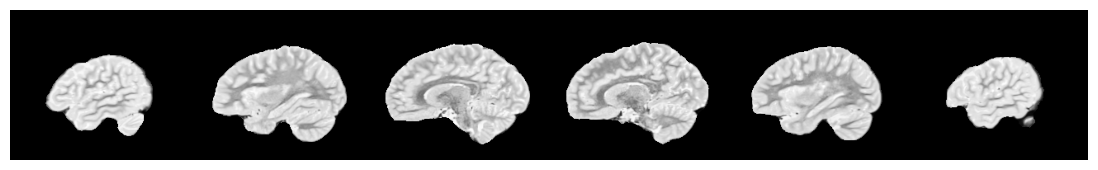

In [82]:
t2.plot(nslices=6)

In [28]:
# plt.imshow(t1_enhanced[:,:,70])

# plt.imshow(labels[:,:,70])
# plt.colorbar()

# lesioned_sample = ants.merge_channels([t1_enhanced,t2_enhanced])
# lesioned_sample.to_filename(f"{dirname}/combined.nii.gz")

# x_ood["label"].shape

# plt.imshow(x_ood["image"][0,30,:,:])
# plt.show()
# plt.imshow(x_ood["label"][0,30,:,:])

In [29]:
%%time
x_scores_ll = -flownet.log_density(x_inlier_scores).cpu()

CPU times: user 1.22 s, sys: 505 ms, total: 1.73 s
Wall time: 2.13 s


In [30]:
x_scores_ll.shape

torch.Size([86, 48, 56, 40])

In [31]:
%%time
x_ood_scores_ll = -flownet.log_density(x_ood_scores).cpu()

CPU times: user 1.03 s, sys: 422 ms, total: 1.45 s
Wall time: 1.33 s


In [32]:
x_img = ants.from_numpy(x_scores_ll.numpy().mean(0))
x_img.shape

(48, 56, 40)

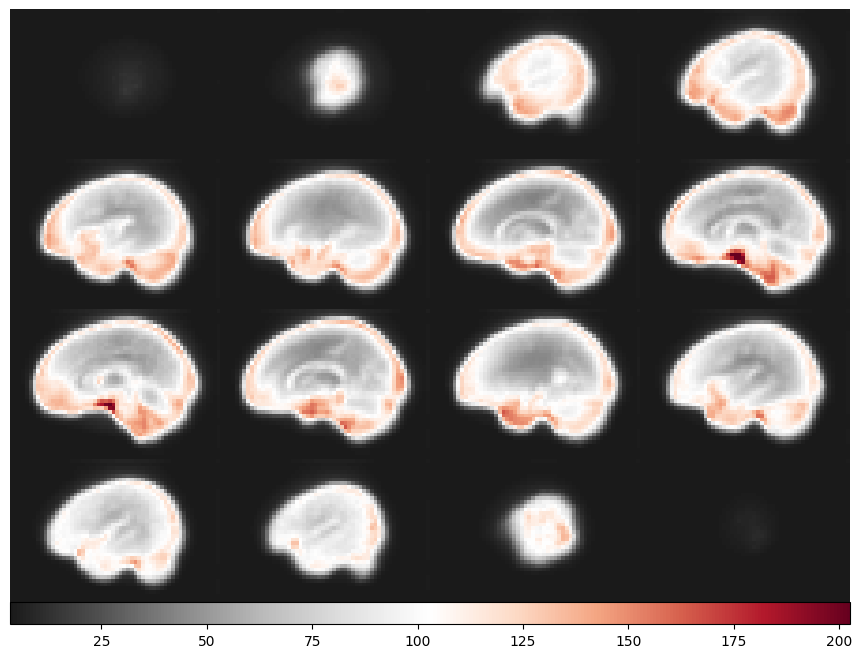

In [207]:
ants.plot(x_img - x_img.min(), overlay=None, nslices=16, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.5, 0.9999),
#           black_bg=False, bg_thresh_quant=0.0001,  bg_val_quant=0.0001
)

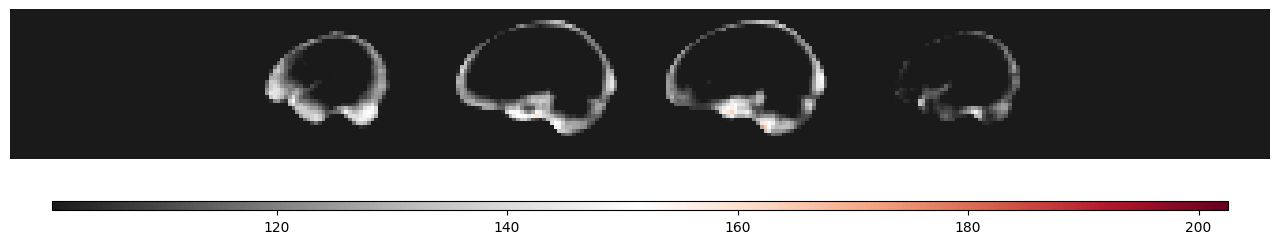

In [41]:
ants.plot(x_img - x_img.min(), overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.9, 0.9999),
#           black_bg=False, bg_thresh_quant=0.0001,  bg_val_quant=0.0001
)

In [18]:
x_ood_scores_ll.min(), x_ood_scores_ll.quantile(0.01)

(tensor(-3.6107), tensor(-2.3314))

In [211]:
img = x_ood_scores_ll.cpu().numpy()[1]
# img = img.clip(max=10)
x_ood_img = ants.from_numpy(img)
t1 = (ants.from_numpy(x_ood[1,0].cpu().numpy()) + 1)*0.5
labels = ants.from_numpy(x_ood_labels[1,0].cpu().numpy())

In [236]:
x_ood.shape

torch.Size([86, 2, 96, 112, 80])

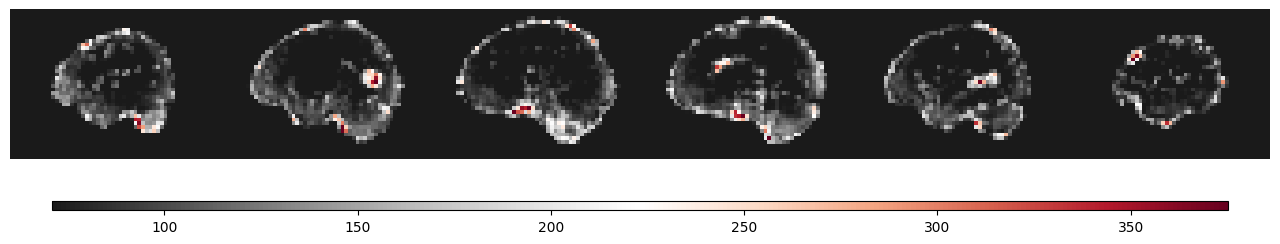

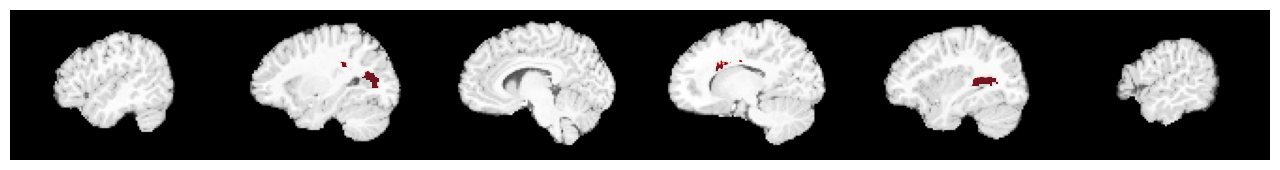

In [212]:
ants.plot(x_ood_img, overlay=None, nslices=6, cmap="RdGy_r", cbar=True, cbar_vertical=False,
#           black_bg=False, bg_thresh_quant=0.1,  bg_val_quant=0.001,
          scale=(0.5, 0.999),
)
t1.plot(overlay=labels, overlay_cmap="Reds", nslices=6)

In [43]:
x_ood.shape, img.shape

(torch.Size([86, 2, 96, 112, 80]), (48, 56, 40))

In [79]:
# ants.plot?

In [202]:
# QUANTILES = np.linspace(0.01, 0.9999, 10)
QUANTILES = np.linspace(0.9, 0.99999, 20)
inlier_quantiles = x_scores_ll.numpy().mean(0).ravel()
inlier_quantiles = np.quantile(inlier_quantiles, q=QUANTILES)
inlier_quantiles

array([ 92.65717163,  94.34175928,  95.83473268,  97.44529466,
        99.04231797, 100.6009312 , 102.25152424, 103.83106887,
       105.47013217, 107.21151566, 108.86550042, 110.83463576,
       112.77765412, 114.63463221, 116.86887141, 119.15701538,
       122.37815765, 126.38568602, 132.76013454, 227.23648529])

/tmp/ipykernel_3161494/4152373011.py:28: UserWarning:

Overwriting the cmap 'inlier_quantile_map' that was already in the registry.



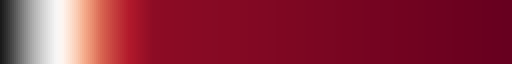

In [286]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors

power_gamma = 2.0

qmin = np.min(inlier_quantiles)
qmax = np.max(inlier_quantiles)
pnorm = mpl.colors.PowerNorm(power_gamma, vmin=qmin, vmax=qmax, clip=False)

mapped_quantiles = (inlier_quantiles - qmin) / (qmax - qmin)

# Build colormap from quantiles
quantile_cmap = mcolors.LinearSegmentedColormap.from_list(
    "inlier_quantile_map",
    [
        (mq, color)
        for mq, color in zip(
            mapped_quantiles,
            mpl.cm.RdGy_r(np.linspace(0, 1, len(mapped_quantiles))),
        )
    ],
    N=256,
)

quantile_cmap.set_over(color="Red")
mpl.colormaps.register(quantile_cmap, force=True)
quantile_cmap

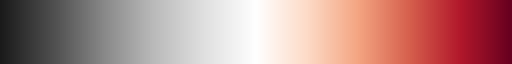

In [287]:
mpl.cm.RdGy_r

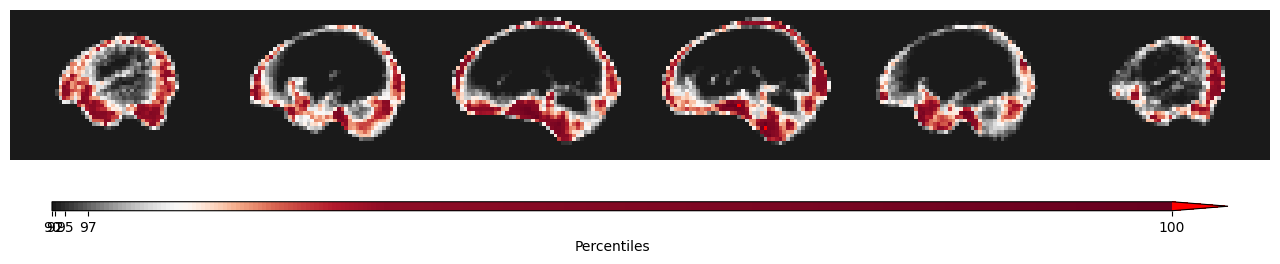

In [288]:
plot_normalized_slices(x_img, overlay=None, nslices=6, scale=False, cbar=True,
                       cbar_vertical=False, norm=pnorm, cmap="inlier_quantile_map")

In [224]:
# np.quantile?

In [233]:
x_img = ants.from_numpy(np.quantile(x_scores_ll.numpy(),q=0.9, axis=0))

In [234]:
# pd.Series(x_scores_ll.numpy().ravel()).hist(bins=50)

In [244]:
t1.shape, x_ood_img.shape

((96, 112, 80), (48, 56, 40))

In [291]:
x_ood_resampled = ants.resample_image(x_ood_img,(0.5,0.5,0.5),False,1)
x_ood_resampled.set_spacing((1,1,1))

In [264]:
x_sample = ants.resample_image(x_ood_img / x_img,(0.5,0.5,0.5),False,1)
x_sample.set_spacing((1,1,1))
x_sample

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

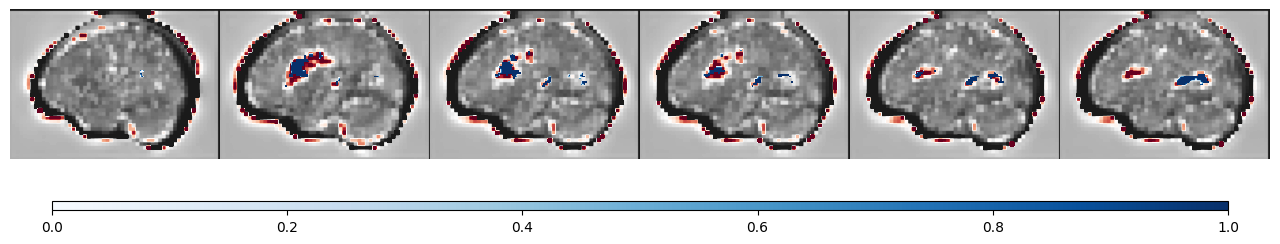

In [289]:
ants.plot(x_sample, overlay=labels, overlay_cmap="Blues",overlay_alpha=1, slices=[32, 60, 61, 62, 63, 64], cmap="RdGy_r",
         scale=(0.01, 0.99), cbar=True, cbar_vertical=False,
)

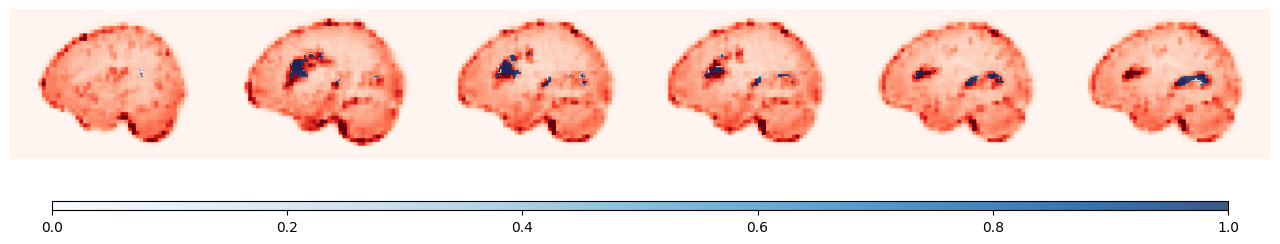

In [304]:
ants.plot(x_ood_resampled, overlay=labels, overlay_cmap="Blues",overlay_alpha=0.8, slices=[32, 60, 61, 62, 63, 64], cmap="Reds",
         scale=(0.01, 0.99), cbar=True, cbar_vertical=False,
)

In [305]:
# ants.ants_image

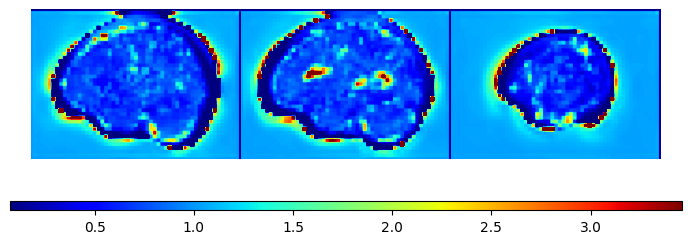

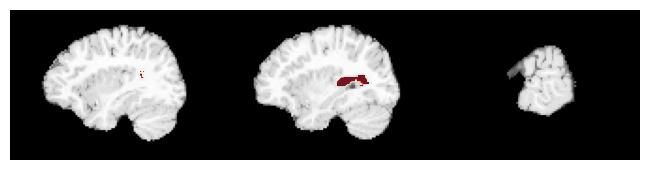

In [266]:
ants.plot(x_sample, overlay=None, slices=[32, 64, 80], scale=(0.01, 0.99), cbar=True, cbar_vertical=False,
          cmap="jet"
#           norm=pnorm, cmap="inlier_quantile_map"
)
ants.plot(t1, overlay=labels, overlay_cmap="Reds", slices=[32, 64, 80])

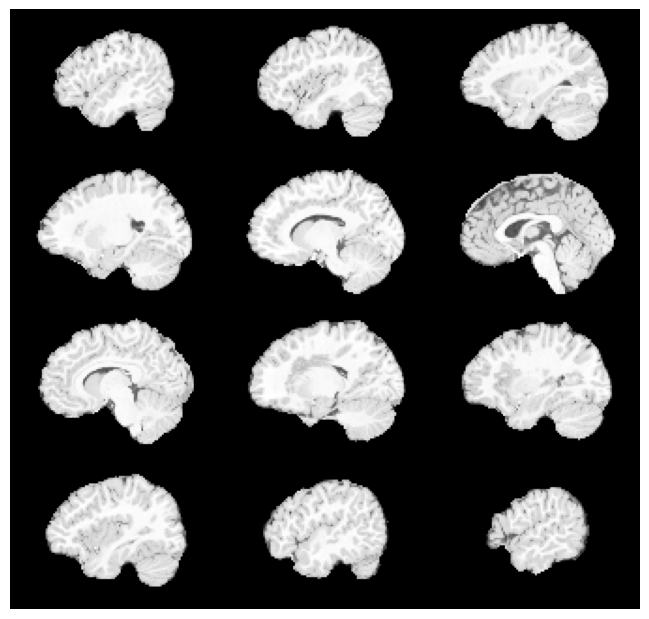

In [241]:
t1.plot()

In [215]:
# x_ood_smothed = ants.smooth_image(x_ood_img, sigma=0.02)
# x_ood_smothed.plot(nslices=6)

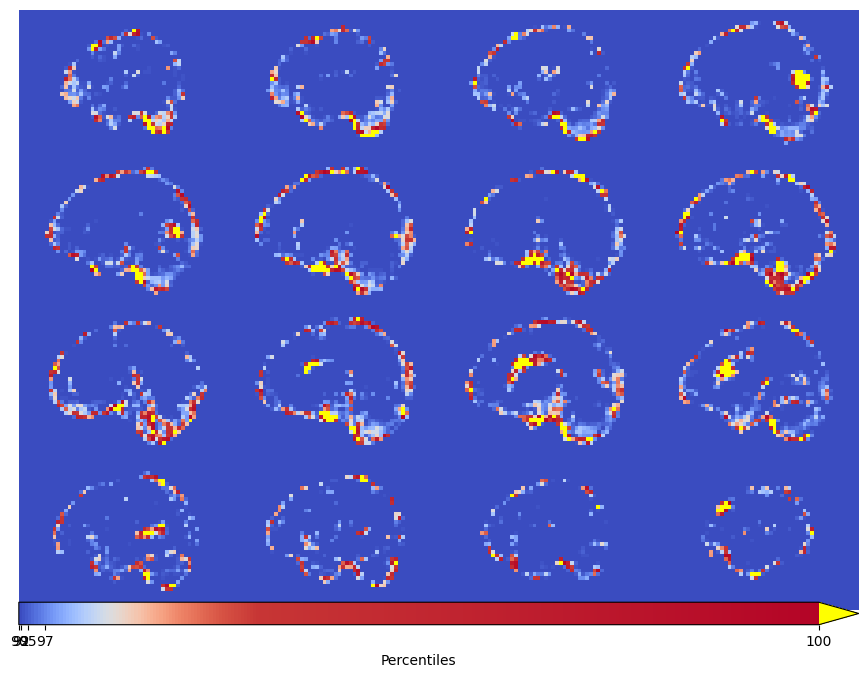

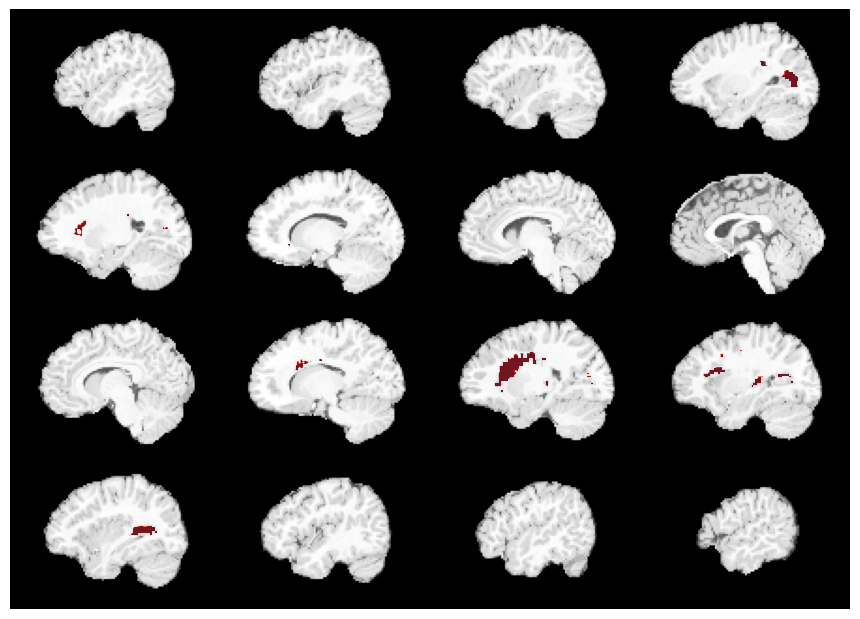

In [216]:
plot_normalized_slices(x_ood_img, overlay=None, nslices=16, scale=False, cbar=True, cbar_vertical=False,
          norm=pnorm, cmap="inlier_quantile_map"
)
t1.plot(overlay=labels, overlay_cmap="Reds", nslices=16)

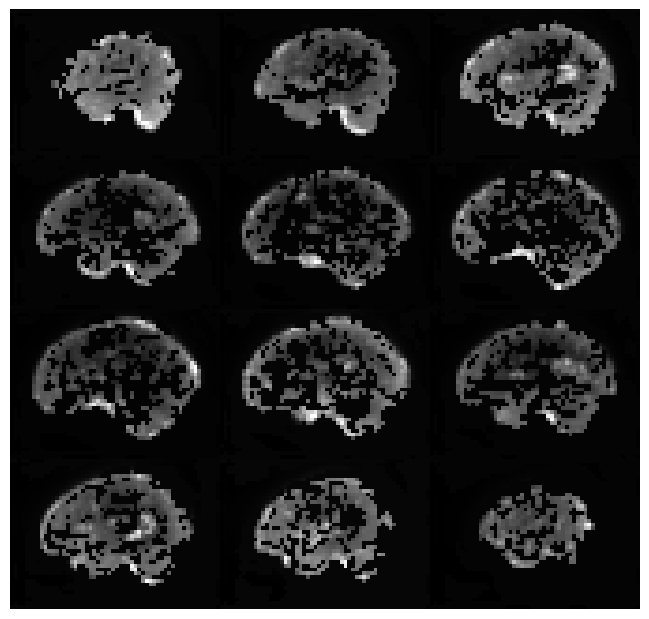

In [190]:
x_ood_clipped = x_ood_smothed * (x_ood_smothed > x_img)
x_ood_clipped.plot()

In [183]:
def plot_normalized_slices(
    image,
    overlay=None,
    blend=False,
    alpha=1,
    cmap="Greys_r",
    overlay_cmap="turbo",
    overlay_alpha=0.9,
    vminol=None,
    vmaxol=None,
    cbar=False,
    cbar_length=0.8,
    cbar_dx=0.0,
    cbar_vertical=True,
    axis=0,
    nslices=12,
    slices=None,
    ncol=None,
    slice_buffer=None,
    black_bg=True,
    bg_thresh_quant=0.01,
    bg_val_quant=0.99,
    domain_image_map=None,
    crop=False,
    scale=False,
    reverse=False,
    title=None,
    title_fontsize=20,
    title_dx=0.0,
    title_dy=0.0,
    filename=None,
    dpi=500,
    figsize=1.5,
    reorient=True,
    resample=True,
    norm=None
):
    from matplotlib import gridspec
    """
    Plot an ANTsImage.

    Use mask_image and/or threshold_image to preprocess images to be be
    overlaid and display the overlays in a given range. See the wiki examples.

    By default, images will be reoriented to 'LAI' orientation before plotting.
    So, if axis == 0, the images will be ordered from the
    left side of the brain to the right side of the brain. If axis == 1,
    the images will be ordered from the anterior (front) of the brain to
    the posterior (back) of the brain. And if axis == 2, the images will
    be ordered from the inferior (bottom) of the brain to the superior (top)
    of the brain.

    ANTsR function: `plot.antsImage`

    Arguments
    ---------
    image : ANTsImage
        image to plot

    overlay : ANTsImage
        image to overlay on base image

    cmap : string
        colormap to use for base image. See matplotlib.

    overlay_cmap : string
        colormap to use for overlay images, if applicable. See matplotlib.

    overlay_alpha : float
        level of transparency for any overlays. Smaller value means
        the overlay is more transparent. See matplotlib.

    axis : integer
        which axis to plot along if image is 3D

    nslices : integer
        number of slices to plot if image is 3D

    slices : list or tuple of integers
        specific slice indices to plot if image is 3D.
        If given, this will override `nslices`.
        This can be absolute array indices (e.g. (80,100,120)), or
        this can be relative array indices (e.g. (0.4,0.5,0.6))

    ncol : integer
        Number of columns to have on the plot if image is 3D.

    slice_buffer : integer
        how many slices to buffer when finding the non-zero slices of
        a 3D images. So, if slice_buffer = 10, then the first slice
        in a 3D image will be the first non-zero slice index plus 10 more
        slices.

    black_bg : boolean
        if True, the background of the image(s) will be black.
        if False, the background of the image(s) will be determined by the
            values `bg_thresh_quant` and `bg_val_quant`.

    bg_thresh_quant : float
        if white_bg=True, the background will be determined by thresholding
        the image at the `bg_thresh` quantile value and setting the background
        intensity to the `bg_val` quantile value.
        This value should be in [0, 1] - somewhere around 0.01 is recommended.
            - equal to 1 will threshold the entire image
            - equal to 0 will threshold none of the image

    bg_val_quant : float
        if white_bg=True, the background will be determined by thresholding
        the image at the `bg_thresh` quantile value and setting the background
        intensity to the `bg_val` quantile value.
        This value should be in [0, 1]
            - equal to 1 is pure white
            - equal to 0 is pure black
            - somewhere in between is gray

    domain_image_map : ANTsImage
        this input ANTsImage or list of ANTsImage types contains a reference image
        `domain_image` and optional reference mapping named `domainMap`.
        If supplied, the image(s) to be plotted will be mapped to the domain
        image space before plotting - useful for non-standard image orientations.

    crop : boolean
        if true, the image(s) will be cropped to their bounding boxes, resulting
        in a potentially smaller image size.
        if false, the image(s) will not be cropped

    scale : boolean or 2-tuple
        if true, nothing will happen to intensities of image(s) and overlay(s)
        if false, dynamic range will be maximized when visualizing overlays
        if 2-tuple, the image will be dynamically scaled between these quantiles

    reverse : boolean
        if true, the order in which the slices are plotted will be reversed.
        This is useful if you want to plot from the front of the brain first
        to the back of the brain, or vice-versa

    title : string
        add a title to the plot

    filename : string
        if given, the resulting image will be saved to this file

    dpi : integer
        determines resolution of image if saved to file. Higher values
        result in higher resolution images, but at a cost of having a
        larger file size

    resample : bool
        if true, resample image if spacing is very unbalanced.

    Example
    -------
    >>> import ants
    >>> import numpy as np
    >>> img = ants.image_read(ants.get_data('r16'))
    >>> segs = img.kmeans_segmentation(k=3)['segmentation']
    >>> ants.plot(img, segs*(segs==1), crop=True)
    >>> ants.plot(img, segs*(segs==1), crop=False)
    >>> mni = ants.image_read(ants.get_data('mni'))
    >>> segs = mni.kmeans_segmentation(k=3)['segmentation']
    >>> ants.plot(mni, segs*(segs==1), crop=False)
    """
    if (axis == "x") or (axis == "saggittal"):
        axis = 0
    if (axis == "y") or (axis == "coronal"):
        axis = 1
    if (axis == "z") or (axis == "axial"):
        axis = 2

    def mirror_matrix(x):
        return x[::-1, :]

    def rotate270_matrix(x):
        return mirror_matrix(x.T)

    def rotate180_matrix(x):
        return x[::-1, ::-1]

    def rotate90_matrix(x):
        return x.T

    def flip_matrix(x):
        return mirror_matrix(rotate180_matrix(x))

    def reorient_slice(x, axis):
        if axis != 2:
            x = rotate90_matrix(x)
        if axis == 2:
            x = rotate270_matrix(x)
        x = mirror_matrix(x)
        return x

    # need this hack because of a weird NaN warning from matplotlib with overlays
#     warnings.simplefilter("ignore")

    # handle `image` argument
#     if isinstance(image, str):
#         image = iio2.image_read(image)
#     if not isinstance(image, iio.ANTsImage):
#         raise ValueError("image argument must be an ANTsImage")

    assert image.sum() > 0, "Image must be non-zero"

    if (image.pixeltype not in {"float", "double"}) or (image.is_rgb):
        scale = False  # turn off scaling if image is discrete

    # handle `overlay` argument
    if overlay is not None:
        if vminol is None:
            vminol = overlay.min()
        if vmaxol is None:
            vmaxol = overlay.max()
        if isinstance(overlay, str):
            overlay = iio2.image_read(overlay)
        if not isinstance(overlay, iio.ANTsImage):
            raise ValueError("overlay argument must be an ANTsImage")

        if not iio.image_physical_space_consistency(image, overlay):
            overlay = reg.resample_image_to_target(overlay, image, interp_type="nearestNeighbor")

        if blend:
            if alpha == 1:
                alpha = 0.5
            image = image * alpha + overlay * (1 - alpha)
            overlay = None
            alpha = 1.0

    # handle `domain_image_map` argument
    if domain_image_map is not None:
        if isinstance(domain_image_map, iio.ANTsImage):
            tx = tio2.new_ants_transform(
                precision="float",
                transform_type="AffineTransform",
                dimension=image.dimension,
            )
            image = tio.apply_ants_transform_to_image(tx, image, domain_image_map)
            if overlay is not None:
                overlay = tio.apply_ants_transform_to_image(
                    tx, overlay, domain_image_map, interpolation="nearestNeighbor"
                )
        elif isinstance(domain_image_map, (list, tuple)):
            # expect an image and transformation
            if len(domain_image_map) != 2:
                raise ValueError("domain_image_map list or tuple must have length == 2")

            dimg = domain_image_map[0]
            if not isinstance(dimg, iio.ANTsImage):
                raise ValueError("domain_image_map first entry should be ANTsImage")

            tx = domain_image_map[1]
            image = reg.apply_transforms(dimg, image, transform_list=tx)
            if overlay is not None:
                overlay = reg.apply_transforms(
                    dimg, overlay, transform_list=tx, interpolator="linear"
                )

    ## single-channel images ##
    if image.components == 1:

        # potentially crop image
        if crop:
            plotmask = image.get_mask(cleanup=0)
            if plotmask.max() == 0:
                plotmask += 1
            image = image.crop_image(plotmask)
            if overlay is not None:
                overlay = overlay.crop_image(plotmask)

        # potentially find dynamic range
        if scale == True:
            vmin, vmax = image.quantile((0.05, 0.95))
        elif isinstance(scale, (list, tuple)):
            if len(scale) != 2:
                raise ValueError(
                    "scale argument must be boolean or list/tuple with two values"
                )
            vmin, vmax = image.quantile(scale)
        else:
            vmin = None
            vmax = None

        # Plot 2D image
        if image.dimension == 2:

            img_arr = image.numpy()
            img_arr = rotate90_matrix(img_arr)

            if not black_bg:
                img_arr[img_arr < image.quantile(bg_thresh_quant)] = image.quantile(
                    bg_val_quant
                )

            if overlay is not None:
                ov_arr = overlay.numpy()
                ov_arr = rotate90_matrix(ov_arr)
                if ov_arr.dtype not in ["uint8", "uint32"]:
                    ov_arr = np.ma.masked_where(ov_arr == 0, ov_arr)

            fig = plt.figure()
            if title is not None:
                fig.suptitle(
                    title, fontsize=title_fontsize, x=0.5 + title_dx, y=0.95 + title_dy
                )

            ax = plt.subplot(111)

            # plot main image
            im = ax.imshow(img_arr, cmap=cmap, alpha=alpha, vmin=vmin, vmax=vmax, norm=norm)

            if overlay is not None:
                im = ax.imshow(ov_arr, alpha=overlay_alpha, cmap=overlay_cmap,
                    vmin=vminol, vmax=vmaxol )

            if cbar:
                cbar_orient = "vertical" if cbar_vertical else "horizontal"
                fig.colorbar(im, orientation=cbar_orient)

            plt.axis("off")

        # Plot 3D image
        elif image.dimension == 3:
            # resample image if spacing is very unbalanced
            spacing = [s for i, s in enumerate(image.spacing) if i != axis]
            was_resampled = False
            if (max(spacing) / min(spacing)) > 3.0 and resample:
                was_resampled = True
                new_spacing = (1, 1, 1)
                image = image.resample_image(tuple(new_spacing))
                if overlay is not None:
                    overlay = overlay.resample_image(tuple(new_spacing))

            if reorient:
                image = image.reorient_image2("LAI")
            img_arr = image.numpy()
            # reorder dims so that chosen axis is first
            img_arr = np.rollaxis(img_arr, axis)

            if overlay is not None:
                if reorient:
                    overlay = overlay.reorient_image2("LAI")
                ov_arr = overlay.numpy()
                if ov_arr.dtype not in ["uint8", "uint32"]:
                    ov_arr = np.ma.masked_where(ov_arr == 0, ov_arr)
                ov_arr = np.rollaxis(ov_arr, axis)

            if slices is None:
                if not isinstance(slice_buffer, (list, tuple)):
                    if slice_buffer is None:
                        slice_buffer = (
                            int(img_arr.shape[1] * 0.1),
                            int(img_arr.shape[2] * 0.1),
                        )
                    else:
                        slice_buffer = (slice_buffer, slice_buffer)
                nonzero = np.where(img_arr.sum(axis=(1, 2)) > 0.01)[0]
                min_idx = nonzero[0] + slice_buffer[0]
                max_idx = nonzero[-1] - slice_buffer[1]
                if min_idx > max_idx:
                    temp = min_idx
                    min_idx = max_idx
                    max_idx = temp
                if max_idx > nonzero.max():
                    max_idx = nonzero.max()
                if min_idx < 0:
                    min_idx = 0
                slice_idxs = np.linspace(min_idx, max_idx, nslices).astype("int")
                if reverse:
                    slice_idxs = np.array(list(reversed(slice_idxs)))
            else:
                if isinstance(slices, (int, float)):
                    slices = [slices]
                # if all slices are less than 1, infer that they are relative slices
                if sum([s > 1 for s in slices]) == 0:
                    slices = [int(s * img_arr.shape[0]) for s in slices]
                slice_idxs = slices
                nslices = len(slices)

            if was_resampled:
                # re-calculate slices to account for new image shape
                slice_idxs = np.unique(
                    np.array(
                        [
                            int(s * (image.shape[axis] / img_arr.shape[0]))
                            for s in slice_idxs
                        ]
                    )
                )

            # only have one row if nslices <= 6 and user didnt specify ncol
            if ncol is None:
                if nslices <= 6:
                    ncol = nslices
                else:
                    ncol = int(round(math.sqrt(nslices)))

            # calculate grid size
            nrow = math.ceil(nslices / ncol)
            xdim = img_arr.shape[2]
            ydim = img_arr.shape[1]

            dim_ratio = ydim / xdim
            fig = plt.figure(
                figsize=((ncol + 1) * figsize * dim_ratio, (nrow + 1) * figsize)
            )
            if title is not None:
                fig.suptitle(
                    title, fontsize=title_fontsize, x=0.5 + title_dx, y=0.95 + title_dy
                )

            gs = gridspec.GridSpec(
                nrow,
                ncol,
                wspace=0.0,
                hspace=0.0,
                top=1.0 - 0.5 / (nrow + 1),
                bottom=0.5 / (nrow + 1),
                left=0.5 / (ncol + 1),
                right=1 - 0.5 / (ncol + 1),
            )

            slice_idx_idx = 0
            for i in range(nrow):
                for j in range(ncol):
                    if slice_idx_idx < len(slice_idxs):
                        imslice = img_arr[slice_idxs[slice_idx_idx]]
                        imslice = reorient_slice(imslice, axis)
                        if not black_bg:
                            imslice[
                                imslice < image.quantile(bg_thresh_quant)
                            ] = image.quantile(bg_val_quant)
                    else:
                        imslice = np.zeros_like(img_arr[0])
                        imslice = reorient_slice(imslice, axis)

                    ax = plt.subplot(gs[i, j])
                    im = ax.imshow(imslice, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm )

                    if overlay is not None:
                        if slice_idx_idx < len(slice_idxs):
                            ovslice = ov_arr[slice_idxs[slice_idx_idx]]
                            ovslice = reorient_slice(ovslice, axis)
                            im = ax.imshow(
                                ovslice, alpha=overlay_alpha, cmap=overlay_cmap,
                                    vmin=vminol, vmax=vmaxol, )
                    ax.axis("off")
                    slice_idx_idx += 1

            if cbar:
                cbar_start = (1 - cbar_length) / 2
                if cbar_vertical:
                    cax = fig.add_axes([0.9 + cbar_dx, cbar_start, 0.03, cbar_length])
                    cbar_orient = "vertical"
                else:
                    cax = fig.add_axes([cbar_start, 0.08 + cbar_dx, cbar_length, 0.03])
                    cbar_orient = "horizontal"
#                 fig.colorbar(im, cax=cax, orientation=cbar_orient)
                    fig.colorbar(
                            mpl.cm.ScalarMappable(cmap=quantile_cmap, norm=pnorm),
                            cax=cax,
                            orientation="horizontal",
                            label="Percentiles",
                            extend="max",
                        )
                    indxs = np.linspace(0, len(inlier_quantiles)-1, 5, dtype=int)
                    labels = [f"{QUANTILES[idx]*100:.0f}" for idx in indxs]
                    positions = inlier_quantiles[indxs]
                    cax.xaxis.set_major_locator(ticker.FixedLocator(positions))
                    cax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))


    ## multi-channel images ##
    elif image.components > 1:
        if not image.is_rgb:
            if not image.components == 3:
                raise ValueError("Multi-component images only supported if they have 3 components")

        img_arr = image.numpy()
        img_arr = img_arr / img_arr.max()
        img_arr = np.stack(
            [rotate90_matrix(img_arr[:, :, i]) for i in range(3)], axis=-1
        )

        fig = plt.figure()
        ax = plt.subplot(111)

        # plot main image
        ax.imshow(img_arr, alpha=alpha)

        plt.axis("off")

    if filename is not None:
        filename = os.path.expanduser(filename)
        plt.savefig(filename, dpi=dpi, transparent=True, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

    # turn warnings back to default
#     warnings.simplefilter("default")

In [175]:
np.linspace(0, 20, 5, dtype=int)

array([ 0,  5, 10, 15, 20])

In [145]:
indxs = [0, 5, 8, 9]
[f"{QUANTILES[idx]*100:.0f}" for idx in indxs]

['90', '96', '99', '100']

In [139]:
QUANTILES

array([0.9   , 0.9111, 0.9222, 0.9333, 0.9444, 0.9555, 0.9666, 0.9777,
       0.9888, 0.9999])